# Federated Learning Model Poisoning Attack Simulation

In [22]:
!git clone https://github.com/JonasGeiping/invertinggradients.git

fatal: destination path 'invertinggradients' already exists and is not an empty directory.


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image
import sys
sys.path.append('/content/invertinggradients')
import inversefed

In [24]:
!pip install -q flwr[simulation] torch torchvision matplotlib

from collections import OrderedDict
from typing import List, Tuple, Optional, Callable
from matplotlib import pyplot as plt
import certifi
import ssl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixed something with matplotlib killing the kernel
ssl._create_default_https_context = ssl._create_unverified_context  # fixed something with the ssl certificate of the dataset
DEVICE = torch.device("cpu")  # "cpu" -> train in cpu | "cuda" -> train in gpu

In [25]:
from logging import WARNING # we need those imports to implement the strategy class
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg, aggregate_krum
from flwr.server.strategy.strategy import Strategy

In [26]:
CLASSES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck") # classes of the example dataset

NUM_CLIENTS = 10 # this is the number of devices participating in the federated learning

BATCH_SIZE = 32 # this is the size of a mini-batch for the training of a CNN using SGD

In [27]:
def load_datasets(): # download and transform cifar-10
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10% validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets() # load the datasets

Files already downloaded and verified
Files already downloaded and verified


In [28]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(

            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [29]:
def train(net, trainloader, epochs: int, verbose=False): # we need a train and a test function that our clients will be using
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):

        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad() # reset the gradients
            outputs = net(images) # do the forward pass
            loss = criterion(outputs, labels) # calculate the loss function
            loss.backward() # calculate the gradients of the loss function
            optimizer.step() # do one stochastic gradient descent step
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total

        if verbose: # log information
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            probas = F.softmax(outputs, dim=1)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(probas.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [30]:
def get_parameters(net) -> List[np.ndarray]: # we need these two function because this way flower knows how
    return [val.cpu().numpy() for _, val in net.state_dict().items()] # to serialize/deserialize data

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [31]:
class FlowerClient(fl.client.NumPyClient): # here we define the FlowerClient. We have to implement only the following 3 methods
    def __init__(self, net, trainloader, valloader): # of course we can customize these methods as we like
        self.net = net                            # we can add extra member variables as well
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [32]:
class BenignFlowerClient(FlowerClient):
    def __init__(self, net, trainloader, valloader):
        super().__init__(net, trainloader, valloader)

    def fit(self, parameters, config):
        #print("Benign Client Got Selected", flush=True)
        parameters, num_examples, _ = super().fit(parameters, config)
        return parameters, num_examples, {"intention": "BENIGN"}

class MaliciousFlowerClient(FlowerClient):
    def __init__(self, net, trainloader, valloader):
        super().__init__(net, trainloader, valloader)

    def fit(self, parameters, config):
        #print("Malicious Client Got Selected", flush=True)
        parameters, num_examples, _ = super().fit(parameters, config)
        return parameters, num_examples, {"intention": "MALICIOUS"}

In [33]:
def client_fn(cid: str) -> FlowerClient: # this is a factory function (factory desing pattern)
    net = LeNet5(10).to(DEVICE) # flower calls this function to create FlowerClients on demand (this way it uses less memory)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    if int(cid) <= NUM_CLIENTS * 0.2:    # 20 - 80 --> malicious - benign
        return MaliciousFlowerClient(net, trainloader, valloader)
    else:
        return BenignFlowerClient(net, trainloader, valloader)

In [34]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics: # we pass this function as an argument to the Strategy
    # calculate accuracy
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # return it as a dictionary
    return {"accuracy": sum(accuracies) / sum(examples)}

In [35]:
setup = inversefed.utils.system_startup()
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

Currently evaluating -------------------------------:
Thursday, 09. November 2023 10:04AM
CPUs: 1, GPUs: 0 on aa3c52d35dc5.


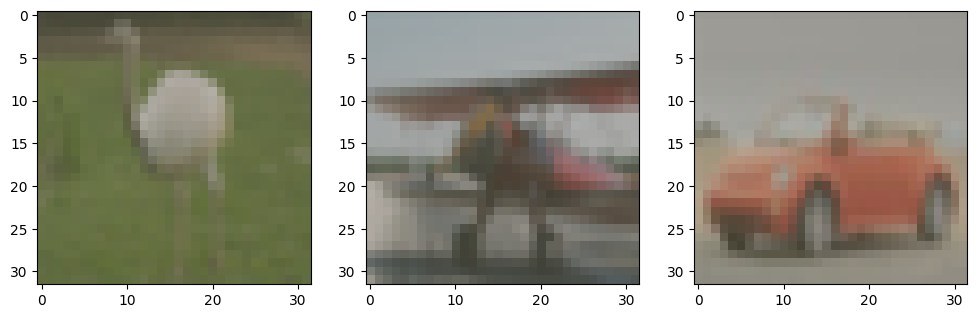

In [36]:
ground_truth = []
ground_truth.append(trainloaders[0].dataset[0][0])
ground_truth.append(trainloaders[0].dataset[5][0])
ground_truth.append(trainloaders[0].dataset[12][0])
ground_truth = torch.stack(ground_truth)
plot(ground_truth)

In [37]:
class AttackSimulationStrategy(fl.server.strategy.FedAvg): # we inherit from FedAvg strategy and change only what we need
    def __init__(self, *, fraction_fit: float = 1.0, fraction_evaluate: float = 1.0, min_fit_clients: int = 2,
        min_evaluate_clients: int = 2, min_available_clients: int = 2, num_malicious_clients: int = 2,
        num_clients_to_keep: int = 0, evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]],
        Optional[Tuple[float, Dict[str, Scalar]]],]] = None, on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None, accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None, fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        perturbationVector: str, adversaryKnowledge: str
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit, fraction_evaluate=fraction_evaluate, min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients, min_available_clients=min_available_clients, evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn, on_evaluate_config_fn=on_evaluate_config_fn, accept_failures=accept_failures,
            initial_parameters=initial_parameters, fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.num_malicious_clients = num_malicious_clients
        self.num_clients_to_keep = num_clients_to_keep
        self.perturbationVector = perturbationVector
        self.adversaryKnowledge = adversaryKnowledge
        self.model_parameters = initial_parameters

    def __repr__(self) -> str:
        rep = f"AttackSimulationStrategy(accept_failures={self.accept_failures})"
        return rep

    def aggregate_fit(self, server_round: int, results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:

        if not results: # boilerplate code to handle exceptions
            return None, {}
        if not self.accept_failures and failures:
            return None, {}

        # convert results
        total_weights_results = [(parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples) for _, fit_res in results]

        ########################################################
        ########### SIMULATE MODEL INVERSION ATTACK ############
        ########################################################
        if server_round == 2:
            modelo = LeNet5(10).to(DEVICE)
            set_parameters(modelo, parameters_to_ndarrays(self.model_parameters))
            criterion = torch.nn.CrossEntropyLoss()
            images = []
            image = trainloaders[0].dataset[0][0]
            images.append(image)
            image = trainloaders[0].dataset[5][0]
            images.append(image)
            image = trainloaders[0].dataset[12][0]
            images.append(image)
            images = torch.stack(images)
            label = torch.as_tensor((trainloaders[0].dataset[0][1],))
            labels = []
            labels.append(label)
            label = torch.as_tensor((trainloaders[0].dataset[5][1],))
            labels.append(label)
            label = torch.as_tensor((trainloaders[0].dataset[12][1],))
            labels.append(label)
            labels = torch.cat(labels)
            outputs = modelo(images) # do the forward pass
            modelo.zero_grad()
            target_loss = criterion(outputs, labels) # calculate the loss function
            input_gradient = torch.autograd.grad(target_loss, modelo.parameters())
            input_gradient = [grad.detach() for grad in input_gradient]
            config = dict(signed=True, boxed=True, cost_fn='sim', indices='def', weights='equal', lr=0.1, optim='adam', restarts=1, max_iterations=4000,
                          total_variation=1e-6, init='randn', filter='none', lr_decay=True, scoring_choice='loss')
            rec_machine = inversefed.GradientReconstructor(modelo, (dm, ds), config, num_images=3)
            output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

            test_mse = (output.detach() - ground_truth).pow(2).mean()
            feat_mse = (modelo(output.detach())- modelo(ground_truth)).pow(2).mean()
            test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

            plot(output)
            plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");
        ########################################################
        ########################################################
        ########################################################

        # calculate AGR
        parameters_aggregated = ndarrays_to_parameters(aggregate_krum( # this thing here is for krum-AGR
            total_weights_results, self.num_malicious_clients, self.num_clients_to_keep))

        # boilerplate code if aggregation metrics are provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")
        self.model_parameters = parameters_aggregated

        return parameters_aggregated, metrics_aggregated



INFO flwr 2023-11-09 10:04:44,226 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-09 10:04:50,592	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-09 10:04:53,503 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7820424807.0, 'object_store_memory': 3910212403.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7820424807.0, 'object_store_memory': 3910212403.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-11-09 10:04:53,511 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-09 10:04:53,516 | app.py:224 | Flower VCE: Resources for each Virtual Clie

It: 0. Rec. loss: 1.0056.
It: 500. Rec. loss: 0.0137.
It: 1000. Rec. loss: 0.0195.
It: 1500. Rec. loss: 0.0220.
It: 2000. Rec. loss: 0.0046.
It: 2500. Rec. loss: 0.0034.
It: 3000. Rec. loss: 0.0023.
It: 3500. Rec. loss: 0.0023.


DEBUG flwr 2023-11-09 10:07:38,011 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


It: 3999. Rec. loss: 0.0022.
Choosing optimal result ...
Optimal result score: 0.0022
Total time: 56.67642426490784.


DEBUG flwr 2023-11-09 10:07:46,632 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-11-09 10:07:46,636 | server.py:222 | fit_round 3: strategy sampled 8 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 8 clients (out of 10)
DEBUG flwr 2023-11-09 10:08:23,831 | server.py:236 | fit_round 3 received 8 results and 0 failures
DEBUG:flwr:fit_round 3 received 8 results and 0 failures
DEBUG flwr 2023-11-09 10:08:23,874 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-11-09 10:08:31,963 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-11-09 10:08:31,967 | server.py:222 | fit_round 4: strategy sampled 8 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 8 clients (out of 10

History (loss, distributed):
	round 1: 0.05362549328804016
	round 2: 0.048794215679168695
	round 3: 0.04868801150321961
	round 4: 0.04624451689720154
	round 5: 0.044618158650398254
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.3872000000000001), (2, 0.446), (3, 0.45999999999999996), (4, 0.48439999999999994), (5, 0.5044000000000001)]}

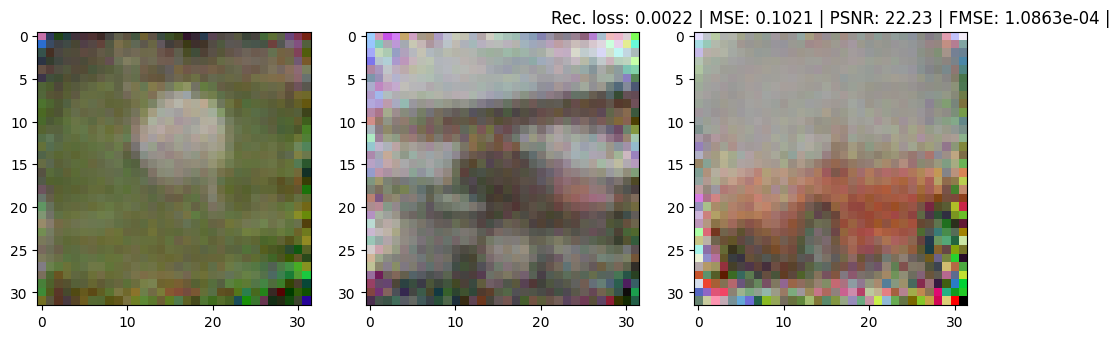

In [38]:

# create a strategy
strategy = AttackSimulationStrategy(fraction_fit=0.8, fraction_evaluate=0.5, min_fit_clients=5,
    min_evaluate_clients=5, min_available_clients=10, perturbationVector="InverseStd", adversaryKnowledge="agr-only",
    evaluate_metrics_aggregation_fn=weighted_average,) # <-- pass the metric aggregation function. This function will be called
                                                       # in every federated learning round for evaluation (it aggregates the
                                                       # client-side evaluation metrics in the server)

# start simulation
fl.simulation.start_simulation(
    client_fn=client_fn, # out factory function
    num_clients=NUM_CLIENTS, # number of clients
    config=fl.server.ServerConfig(num_rounds=5), # number of federated learning rounds
    strategy=strategy, # our attack simulation strategy
    client_resources=None,
)